# Two types of local coherence in the SOSP model

So far, the model reliably produces *lexical* but not *syntactic* local coherence effects. As we'll see below, this is due to how the attractors are laid out: the lexical local coherence is closer to the initial condition after reading *tossed* than the syntactic local coherence is.

In [1]:
# Importing and setting up
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # additional plotting tools
# the word-by-word system; there's also a simpler interface for running the smaller models we've done before
import sosp.incremental as inc

# Lexicon & corpus
file = './LCLexicon02.yaml'
corp = [['at', 'player', 'tossed'], ['at', 'player', 'thrown']]
#corp = [['smiled', 'at', 'player', 'tossed'],['smiled', 'at', 'player', 'thrown']]#,
#        ['player', 'tossed', 'EMPTY'], ['at', 'player', 'EMPTY'],
#        ['player', 'smiled', 'EMPTY'], ['player', 'smiled', 'at']]
#corp = [['player', 'tossed'], ['player', 'thrown']]
sent_len = max([len(i) for i in corp])

# Creating the system
sys = inc.Struct(lex_file=file, features=['N', 'Prep', 'MainVerb', 'Participle'],
                 max_sent_length=sent_len, missing_link_cost=0.5, gamma=0.4,
                 stopping_crit='cheb_stop', corpus=corp)

# Finishing setup
sys.gen_centers()
sys.calculate_local_harmonies()
sys.locate_attrs()

Naming position dimensions...
Naming links...
Naming links...
Naming links...
Number of centers generated: 39
Found 37 unique attractors from 39 centers


In [146]:
from scipy.spatial.distance import pdist
np.min(pdist(sys.centers)) / 2 * 0.8

0.4

We're now ready to do some test runs, first with the control (*thrown*) condition.

/Users/garrettsmith/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


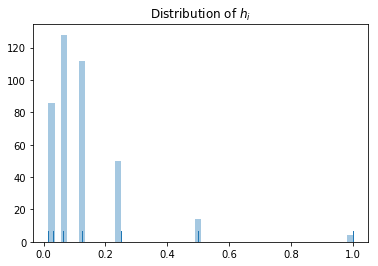

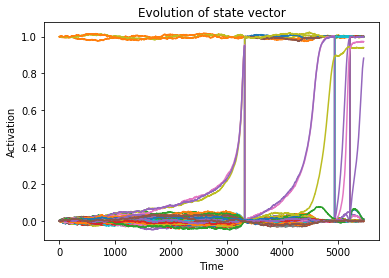

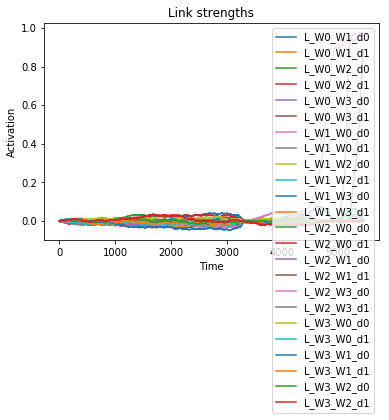

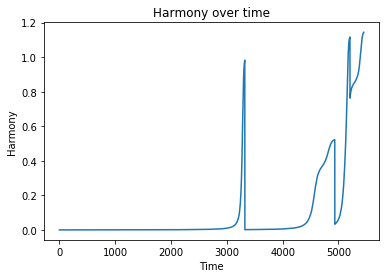

Active dimensions at the end of processing:
 ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_thrown', 'W3_Participle', 'W3_d0_N', 'L_W1_W0_d0', 'L_W2_W1_d0', 'L_W3_W2_d0'] 

Basic data output: word number, word, processing time
 [[0, 'smiled', 3322], [1, 'at', 1612], [2, 'player', 271], [3, 'thrown', 248]] 



In [148]:
sys.set_params(noise_mag=1e-5)
# Running
final, data = sys.single_run(corp[1])  # Do a single run with the "thrown" condition

# Plotting
sns.distplot(sys.local_harmonies, kde=False, rug=True)
plt.title('Distribution of $h_i$')
plt.show()
sys.plot_trace()  # The whole state vector over time
sys.plot_links()  # Just the links
sys.plot_harmony()  # Harmony over time
print('Active dimensions at the end of processing:\n', sys.which_nonzero(np.round(final)), '\n')
print('Basic data output: word number, word, processing time\n', data, '\n')

Unsurprisingly, the system processed this string correctly. At the end of processing, all of the correct dimensions are active, and the words are correctly linked; `L_W1_W0_d0` means that word 1 (*player*) is linked to word 0's (*at*) 0th dependent attachment site, and `L_W2_W1_d0` means the participle is attached as *player*'s RCmod dependent.

Now, a single run of the *tossed* condition.

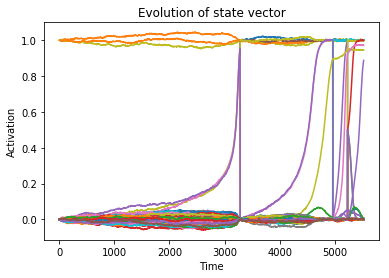

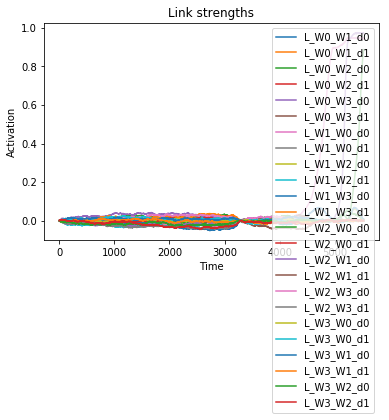

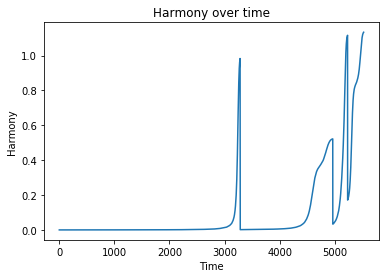

Active dimensions at the end of processing:
 ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_tossed', 'W3_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0', 'L_W3_W2_d0'] 

Basic data output: word number, word, processing time
 [[0, 'smiled', 3282], [1, 'at', 1681], [2, 'player', 268], [3, 'tossed', 292]] 



In [149]:
final2, data2 = sys.single_run(corp[0])
sys.plot_trace()
sys.plot_links()
sys.plot_harmony()
print('Active dimensions at the end of processing:\n', sys.which_nonzero(np.round(final2)), '\n')
print('Basic data output: word number, word, processing time\n', data2, '\n')

It looks like it settled on the correct parse.

Now, we want to get the state of system after reading *tossed*.

In [170]:
# Getting the state when ambig word is introduced
#idx = data2[0][2] + data[1][2] + 2
#idx = data2[0][2] + 1
idx = data2[0][2] + data[1][2] + data2[2][2] + 72
print(sys.which_nonzero(np.rint(sys.state_hist[idx,])))
names = sys.which_nonzero(np.rint(sys.state_hist[idx,]))
idx = [sys.dim_names.index(dn) for i, dn in enumerate(sys.dim_names) if dn in names]
# Creating a for use below in calculating distances 
starting_vec = np.zeros(sys.state_hist.shape[1])
for i in idx:
    starting_vec[i] = 1.

['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_tossed', 'L_W1_W0_d0', 'L_W2_W1_d0']


We now run multiple runs in each condition to see which attractors it settles on.

In [171]:
print('Running control...')
ctl = sys.many_runs(100, corp[1])  # 100 runs using the "thrown" condition"
print('\nRunning local coherence condition...')
lc = sys.many_runs(100, corp[0])  # 100 runs with "tossed"

Running control...
Run number:
[0] [10] [20] [30] [40] [50] [60] [70] [80] [90] 
Running local coherence condition...
Run number:
[0] [10] [20] [30] [40] [50] [60] [70] [80] [90] 

In [172]:
print('Control summary:\n------------')
print(ctl.groupby('WordNr').agg({'WordRT': ['mean', 'std', 'max']}))
print('\n\nLocal coherence summary:\n------------')
print(lc.groupby('WordNr').agg({'WordRT': ['mean', 'std', 'max']}))

Control summary:
------------
         WordRT                  
           mean         std   max
WordNr                           
0       3113.41  340.857685  4179
1       1666.77   60.382594  1830
2        266.45    2.928008   272
3        248.93    2.507584   257


Local coherence summary:
------------
         WordRT                  
           mean         std   max
WordNr                           
0       3135.88  362.660825  4626
1       1662.52   56.832819  1797
2        266.38    2.423704   272
3        291.89    2.386388   299


On average, the two conditions produce comparable processing times for *at* and *player*, but they diverge at the participle, with *tossed* taking longer than *thrown*.

The next cell presents the mean processing times by the attractor that the system picked, then the cells after that aggregate the data and display the active dimensions for each of those attractors.

In [180]:
print(ctl[ctl['WordNr'] == 3].groupby('FinalCenterNr').agg({'WordRT': ['mean', 'std', 'min', 'max', 'count']}))
print(lc[lc['WordNr'] == 3].groupby('FinalCenterNr').agg({'WordRT': ['mean', 'std', 'min', 'max','count']}))

               WordRT                          
                 mean       std  min  max count
FinalCenterNr                                  
79             248.93  2.507584  242  257   100
               WordRT                          
                 mean       std  min  max count
FinalCenterNr                                  
341            291.89  2.386388  285  299   100


In [181]:
import pandas as pd
ctl['Cond'] = 'ctl'
lc['Cond'] = 'lc'
full_data = pd.concat([ctl, lc], ignore_index=True)
final_attrs = full_data.FinalCenterNr.unique()
for c in final_attrs:
    print('Attractor {0:02d}'.format(c), sys.which_nonzero(sys.centers[c,]), '\n')
    print(sys.look_up_center(sys.which_nonzero(sys.centers[c,])), '\n')

Attractor 79 ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_thrown', 'W3_Participle', 'W3_d0_N', 'L_W1_W0_d0', 'L_W2_W1_d0', 'L_W3_W2_d0'] 

Local harmony: [1.]
Center number: (array([79]),)
Center: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
None 

Attractor 341 ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_tossed', 'W3_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0', 'L_W3_W2_d0'] 

Local harmony: [1.]
Center number: (array([341]),)
Center: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

The *thrown* condition only approaches the grammatical attractor, as expected. *Tossed* takes longer for both attractors that it approaches because it is ambiguous between. It always settles on either the correct parse (center 26) or the lexical local coherence (center 11), where *tossed* (main verb) fails to attach to the rest of the structure.

We want the system to go to the syntactic local coherence at least sometimes, though, so now we'll look at how far apart the relevant states are. We first look at which dimensions are active in each one.

In [188]:
# Syn. LC
syn_lc = ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N',
          'W2_d0_Participle', 'W3_tossed', 'W3_MainVerb', 'W3_d0_N', 'L_W1_W0_d0', 'L_W2_W3_d0', 'L_W3_W1_d0']
# Making sure that the syn. LC parse is actually an attractor; it is.
sys.look_up_center(syn_lc)

# Active dimensions:
print('\nInitial state: ', sys.which_nonzero(starting_vec))
#print('\nLexical LC: ', sys.which_nonzero(sys.centers[11]))
print('\nSyntactic LC:', syn_lc)
print('\nCorrect: ', sys.which_nonzero(sys.centers[341]))

Local harmony: [0.5]
Center number: (array([227]),)
Center: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]

Initial state:  ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_tossed', 'L_W1_W0_d0', 'L_W2_W1_d0']

Syntactic LC: ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_tossed', 'W3_MainVerb', 'W3_d0_N', 'L_W1_W0_d0', 'L_W2_W3_d0', 'L_W3_W1_d0']

Correct:  ['W0_smiled', 'W0_MainVerb', 'W0_d0_Prep', 'W1_at', 'W1_Prep', 'W1_d0_N', 'W2_player', 'W2_N', 'W2_d0_Participle', 'W3_tossed', 'W3_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0', 'L_W3_W2_d0']


So, from the initial state after reading *tossed*, the system only has to turn on the features of *tossed* to get to the lexical LC attractor. To get to the syntactic LC attractor, it has to turn off the *at*-*player* link and turn on the *player*-*tossed* link, in addition to activating *tossed*'s features.

Next, we see that the Euclidean distances are indeed different. The system only has to travel $\sqrt{2}$ units to get to the lexical LC, but it has to travel 2 units to get to the syntactic LC.

In [189]:
from scipy.spatial.distance import cdist
for c in final_attrs.tolist() + [227]:
    d = cdist(starting_vec.reshape(1, -1), sys.centers[c].reshape(1, -1))
    h = sys.local_harmonies[c]
    print('Dist. between starting point and attractor {}: {}\t{}'.format(c, d, h))

Dist. between starting point and attractor 79: [[2.23606798]]	1.0
Dist. between starting point and attractor 341: [[1.41421356]]	1.0
Dist. between starting point and attractor 227: [[2.23606798]]	0.5


In [190]:
# Checking...
syn_lc = ['W0_at', 'W0_Prep', 'W0_d0_N', 'W1_player', 'W1_N', 'W1_d0_Participle', 'W2_tossed',
                    'W2_MainVerb', 'W2_d0_N', 'L_W2_W0_d0']
# Making sure that the syn. LC parse is actually an attractor; it is.
sys.look_up_center(syn_lc)

Active dimensions don't correspond to a center.


In [191]:
cdist(starting_vec.reshape(1, -1), sys.centers[19,].reshape(1, -1))

array([[2.82842712]])